In [ ]:
#hide
from utils import *
from IPython.display import display,HTML

# Data munging with fastai

In the previous chapter, we showed on examples of texts what `Tokenizer` or a `Numericalize` do to a collection of texts, to explain the usual preprocessing in NLP. We then switched to the data block API, that handles those transforms for us directly using the `TextBlock`. But what if we want to only apply one of those transforms, either to see intermediate results or because we have already tokenized texts. More generally, what can we do when the data block API is not flexible enough to accommodate our particular use case?

In this chapter, we will saw how to use what we call the mid-level API for processing data. The data block API is built on top of that layer, so it will allow you to do everything the data block API does, and much much more! After looking at all the pieces that compose it on our example to preprocess text (like in the last chapter), we will show you an example of preparing data for a Siamese Network, which is a model that takes two images as inputs, and has to predict if those images are of the same class or not.

## The mid-level API for data collection

The fastai library is built on a layered API. At the very top, you have functions that allow you to train a model in five lines of codes, as we saw in <<chapter_intro>>. In the case of collecting data for a text classifier for instance, we used the line:

In [ ]:
from fastai2.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

The factory method `TextDataLoaders.from_folder` is very convenient when your data is arranged the exact same way as the IMDb dataset, but in practice, that often won't be the case. The high-level API for data collection is the data block API and offers more flexibility. As we saw in the last chapter, we can ge the same result with:

In [ ]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

But it's sometimes not flexible enough. For debugging purposes for instance, we might need to apply just parts of the transforms that come with this data block. So let's dig into the pieces that we used to write this data block API.

> note: The mid-level API in general does not only contain functionality for data collection. It also has the callback system that we will study in <<chapter_callbacks>>, which allows us to customize the training loop any way we like, and the general optimizer that we will cover in <<chapter_accel_sgd>>.

### Transforms and Pipelines

When we studied tokenization and numericalization in the last chapter, we started by grabbing a bunch of texts:

In [ ]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

We then showed how to tokenize them with a `Tokenizer`:

In [ ]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#374) ['xxbos','xxmaj','well',',','"','cube','"','(','1997',')'...]

And how to numericalize an automatically create the vocab for our corpus:

In [ ]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

tensor([   2,    8,   76,   10,   23, 3112,   23,   34, 3113,   33])

For each of those steps, we created an object (`tok` or `num`) called the setup method (which trains the tokenizer if needed for `tok` and creates the vocab for `nums`) then applied it on our raw texts. 

There is a general behavior here that is used in all data preprocessing, that we captured in a class called `Transform`. Both `tok` and `num` are `Transform`s, and in general, a transform is a function that will be applied to your data *lazily* (that means when you ask for it and not all at once, because we don't want to load all images in memory at once, for instance, in computer vision) with an optional *setup* that will initialize some inner state (like the vocab inside `num` for instance).

fastai's `Transform`s have two more functionality. The first one is that they can optionally reverse their transformation with a *decode* method. This is what is used inside fastai for all the show methods we have seen. For instance, `num` has a decode method that will give us back the tokenized text:  

In [ ]:
num.decode(nums[0])[:100]

'xxbos xxmaj well , " cube " ( 1997 ) , xxmaj vincenzo \'s first movie , was one of the most interesti'

On the other end, when looking at our data, we would like to see the result of the tokenization, to make sure none of the rules damaged the texts, so `tok` does not have a decode method (in practice, it has one that does nothing). It's the same for data augmentation transforms: since we want to show the effects on images, to make sure we didn't do too much data augmentation (or not enough) we don't decode those transforms. However, we need to undo the effects of the `Normalize` transform we saw in <<chapter_sizing_and_tta>> to be able to plt the images, so this one has a decode method.

The second special behavior of `Transform`s is that they always get applied over tuples: in general, our data is always a tuple `(input,target)` (sometimes with more than one input or more than one target). When applying a transform on an item like this, such as `Resize`, we don't want to resize the tuple, but resize the input (if applicable) and the target (if applicable). It's the same for the batch transforms that do data augmentation: when the input is an image and the target is a segmentation mask, the transform needs to be applied (the same way) to the input and the target.

We can see this behavior if we pass a tuple of texts to `tok`:

In [ ]:
tok((txts[0], txts[1]))

((#374) ['xxbos','xxmaj','well',',','"','cube','"','(','1997',')'...],
 (#207) ['xxbos','xxmaj','conrad','xxmaj','hall','went','out','with','a','bang'...])

### Sidebar: Writing your own Transform

If you want to write a custom transform to apply to your data, the easiest way is to write a function:

In [ ]:
def f(x): return x+1
tfm = Transform(f)

`tfm` will automatically convert `f` to a `Transform` with no setup and no decode method. If you need either of those, you will need to subclass `Transform`. When writing this subclass, you need to implement the actual function in `encodes`, then (optionally), the setup behavior in `setups` and the decoding behavior in `decodes`:

In [ ]:
class MyTfm(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x+self.mean
    def decodes(self, x): return x-self.mean

Here `MyTfm` will initialize some states during the setup (the mean of all elements passed), then the transformation is to add that mean. For decoding purposes, we implement the reverse of that transformation by subtracting the mean. Here is an example of `myTfm` in action:

In [ ]:
tfm = MyTfm()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, 5.0, 2.0)

To learn more about `Transform`s and how you can use them to have different behavior depending on the type of the input, be sure to check our tutorial in the docs online.

### End sidebar

To compose several transforms together, fastai uses `Pipeline`. You can define a `Pipeline` by passing it a list of `Transform`s and it will then compose the transforms incide it: when you call it on an object, it will automatically call the transforms inside in order:

In [ ]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

tensor([   2,    8,   76,   10,   23, 3112,   23,   34, 3113,   33,   10,    8, 4477,   22,   88,   32,   10,   27,   42,   14])

And you can call decode on the result of your encoding, to get back something you can display and analyze:

In [ ]:
tfms.decode(t)[:100]

'xxbos xxmaj well , " cube " ( 1997 ) , xxmaj vincenzo \'s first movie , was one of the most interesti'

The only part that doesn't work the same way as in `Transform` is the setup. To properly setup a `Pipeline` of `Transform`s on some data, you need to use a `TfmdLists`.

### TfmdLists and Datasets

You data is usually a set of raw items (like filenames, or rows in a dataframe) to which you want to apply a succession of transformations. We just saw that the succession of transformations was represented by a `Pipeline` in fastai. The class that groups together this pipeline with your raw items is called `TfmdLists`. Here is the short way of doing the transformation we saw in the previous section:

In [ ]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

At initialization, the `TfmdLists` will automatically call the setup method of each transform in order, providing them not with the raw items but the items transformed by all the previous `Transform`s in order. We can get the result of our pipeline on any raw element just by indexing into the `TfmdLists`:

In [ ]:
t = tls[0]; t[:20]

tensor([    2,     8,    91,    11,    22,  5793,    22,    37,  4910,    34,    11,     8, 13042,    23,   107,    30,    11,    25,    44,    14])

And the `TfmdLists` knows how to decode for showing purposing:

In [ ]:
tls.decode(t)[:100]

'xxbos xxmaj well , " cube " ( 1997 ) , xxmaj vincenzo \'s first movie , was one of the most interesti'

In fact, it even has a `show` method:

In [ ]:
tls.show(t)

xxbos xxmaj well , " cube " ( 1997 ) , xxmaj vincenzo 's first movie , was one of the most interesting and tricky ideas that xxmaj i 've ever seen when talking about movies . xxmaj they had just one scenery , a bunch of actors and a plot . xxmaj so , what made it so special were all the effective direction , great dialogs and a bizarre condition that characters had to deal like rats in a labyrinth . xxmaj his second movie , " cypher " ( 2002 ) , was all about its story , but it was n't so good as " cube " but here are the characters being tested like rats again . 

 " nothing " is something very interesting and gets xxmaj vincenzo coming back to his ' cube days ' , locking the characters once again in a very different space with no time once more playing with the characters like playing with rats in an experience room . xxmaj but instead of a thriller sci - fi ( even some of the promotional teasers and trailers erroneous seemed like that ) , " nothing " is a loose and light comedy that

The `TfmdLists` is named with an "s" because it can handle a training and validation set with a splits argument. You just need to pass the indices of which elemets are in the training set, and which are in the validation set:

In [ ]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], splits=splits)

You can then access them through the `train` and `valid` attribute:

In [ ]:
tls.valid[0][:20]

tensor([    2,     8,    20,    30,    87,   510,  1570,    12,   408,   379,  4196,    10,     8,    20,    30,    16,    13, 12216,   202,   509])

If you have manually written a `Transform` that returns your whole data (input and target) from the raw items you had, then `TfmdLists` is the class you need. You can directly convert it to a `DataLoaders` object with the `dataloaders` method. This is what we will do in our Siamese example further in this chapter.

In general though, you have two (or more) parallel pipelines of transforms: one for processing your raw items into inputs and one to process your raw items into targets. For instance, here, the pipeline we defined only processes the input. If we want to do text classification, we have to process the labels as well. 

Here we need to do two things: first take the label name from the parent folder. There is a function `parent_label` for this:

In [ ]:
lbls = files.map(parent_label)
lbls

(#50000) ['pos','pos','pos','pos','pos','pos','pos','pos','pos','pos'...]

Then we need a `Transform` that will grab the unique items and build a vocab with it during setup, then will transform the string labels into integers when called. fastai provides this transform, it's called `Categorize`:

In [ ]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

((#2) ['neg','pos'], TensorCategory(1))

To do the whole setup automatically on our list of files, we can create a `TfmdLists` as before:

In [ ]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(1)

But then we end up with two separate objects for our inputs and targets, which is not what we want. This is where `Datasets` comes to the rescue. `Datasets` will apply two (or more) pipelines in parallel to the same raw object and build a tuple with the result. Like `TfmdLists`, it will automatically do the setup for us, and when we index into a `Datasets`, it will return us a tuple with the results of each pipeline:

In [ ]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

Like a `TfmdLists`, we can pass along `splits` to a `Datasets` to split our data between training and validation:

In [ ]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(tensor([    2,     8,    20,    30,    87,   510,  1570,    12,   408,   379,  4196,    10,     8,    20,    30,    16,    13, 12216,   202,   509]),
 TensorCategory(0))

It can also decode any processed tuple or show it directly:

In [ ]:
t = dsets.valid[0]
dsets.decode(t)

('xxbos xxmaj this movie had horrible lighting and terrible camera movements . xxmaj this movie is a jumpy horror flick with no meaning at all . xxmaj the slashes are totally fake looking . xxmaj it looks like some 17 year - old idiot wrote this movie and a 10 year old kid shot it . xxmaj with the worst acting you can ever find . xxmaj people are tired of knives . xxmaj at least move on to guns or fire . xxmaj it has almost exact lines from " when a xxmaj stranger xxmaj calls " . xxmaj with gruesome killings , only crazy people would enjoy this movie . xxmaj it is obvious the writer does n\'t have kids or even care for them . i mean at show some mercy . xxmaj just to sum it up , this movie is a " b " movie and it sucked . xxmaj just for your own sake , do n\'t even think about wasting your time watching this crappy movie .',
 'neg')

The last step is to convert your `Datasets` object to a `DataLoaders`, which can be done with the `dataloaders` method. Here we need to pass along special arguments to take care of the padding problem (as we saw in the last chapter). This needs to happen just before we batch the elements, so we pass it to `before_batch`: 

In [ ]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

`dataloaders` directly calls `DataLoader` on each subset of our `Datasets`. fastai's `DataLoader` expands the PyTorch class of the same name and is responsible for collating the items from our datasets into batches. It has a lot of points of customization but the most important you should know are:

- `after_item`: applied on each item after grabbing it inside the dataset. This is the equivalent of the `item_tfms` in `DataBlock`.
- `before_batch`: applied on the list of items before they are collated. This is the ideal place to pad items to the same size.
- `after_batch`: applied on the batch as a whole after its construction. This is the equivalent of the `batch_tfms` in `DataBlock`.

As a conclusion, here is the full code necessary to prepare the data for text classification:

In [ ]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

The two differences with what we had above is the use of `GrandParentSplitter` to split our training and validation data, and the `dl_type` argument. This is to tell `dataloaders` to use the `SortedDL` class of `DataLoader`, and not the usual one. This is the class that will handle the construction of batches by putting samples of roughly the same lengths into batches.

This does the exact same thing as our `DataBlock` from above:

In [ ]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

...except that now, yuo know how to customize every single piece of it!

Let's practice what we just learned on this mid-level API for data preprocessing on a computer vision example now, with a Siamese Model input pipeline.

## Siamese model

A Siamese model takes two images and has to determine if they are of the same class or not. For this example, we will use the pets dataset again, and prepare the data for a model that will have to predict if two images of pets are of the same breed or not. TK see if we train that model later in the book. 

In [ ]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [ ]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        dim = 2 if isinstance(img1, Tensor) else 1
        return show_image(torch.cat([tensor(img1),tensor(img2)], dim=dim), 
                          title=same_breed, ctx=ctx)

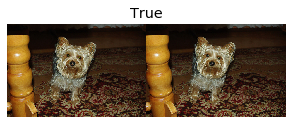

In [ ]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show()

In [ ]:
tst = ToTensor()(s)

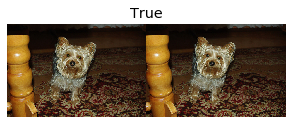

In [ ]:
tst.show()

All in one transform

In [ ]:
class SiamesePair(Transform):
    def __init__(self,items,labels):
        self.items,self.labels,self.assoc = items,labels,self
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        # dict of (each unique label) -- (list of indices with that label)
        self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items)
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        othercls = self.clsmap[self.labels[i]] if random.random()>0.5 else self.idxs
        otherit = random.choice(othercls)
        return SiameseImage(self.items[i], self.items[otherit], self.labels[otherit]==self.labels[i])